In [6]:
using Statistics
using CairoMakie
using CairoMakie.Colors
using Interpolations
include("src-fig/plotting.jl")
foldername = "../scratch/turbulence-at-fronts/Strain"

iterations, times = iterations_times(foldername)
sp = simulation_parameters(foldername)
#sp = create_simulation_parameters(; sp...)
xsᶜ, xsᶠ, ysᶜ, ysᶠ, zsᶜ, zsᶠ = grid_nodes(foldername)
inds = centre_indices(foldername)
frames = [401, 581, 941];

LoadError: KeyError: key "zᵃᵃᶜ" not found

In [7]:
file = jldopen(joinpath(foldername, "output.jld2"))

JLDFile /scratch/atkin163/turbulence-at-fronts/Strain/output.jld2 (read-only)
 ├─🔢 author
 ├─🔢 comment
 ├─📂 grid
 │  ├─🔢 Nx
 │  ├─🔢 Ny
 │  ├─🔢 Nz
 │  ├─🔢 Hx
 │  ├─🔢 Hy
 │  └─ ⋯ (13 more entries)
 └─ ⋯ (3 more entries)

In [18]:
nodes(file["serialized/grid"])

LoadError: UndefVarError: `nodes` not defined

In [4]:
]add ImageFiltering

   Resolving package versions...
   Installed SciMLPublic ──── v1.0.0
   Installed Static ───────── v1.3.0
   Installed ArrayInterface ─ v7.20.0
   Installed ImageFiltering ─ v0.7.12
    Updating `~/.julia/environments/v1.10/Project.toml`
  [6a3955dd] + ImageFiltering v0.7.12
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [4fba245c] + ArrayInterface v7.20.0
  [aafaddc9] + CatIndices v0.2.2
  [f70d9fcc] + CommonWorldInvalidations v1.0.0
  [ed09eef8] + ComputationalResources v0.3.2
  [dc8bdbbb] + CustomUnitRanges v1.0.2
  [4f61f5a4] + FFTViews v0.3.2
  [615f187c] + IfElse v0.1.1
  [6a3955dd] + ImageFiltering v0.7.12
  [431bcebd] + SciMLPublic v1.0.0
  [aedffcd0] + Static v1.3.0
  [0d7ed370] + StaticArrayInterface v1.8.0
  [06e1c1a7] + TiledIteration v0.5.0
Precompiling packages...
    819.0 ms  ✓ CustomUnitRanges
    721.4 ms  ✓ IfElse
    708.4 ms  ✓ CommonWorldInvalidations
    819.3 ms  ✓ SciMLPublic
    919.8 ms  ✓ ArrayInterface
   1161.1 ms  ✓ ComputationalResources
   

## Pre-initial conditions

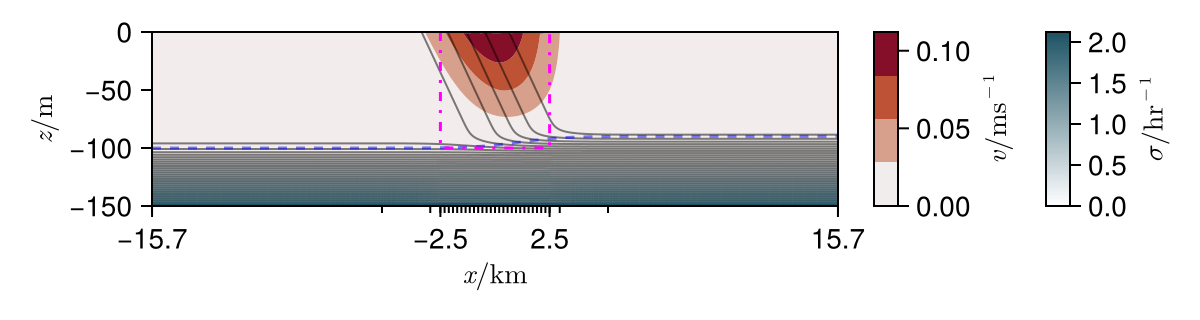

In [45]:
include("src-fig/preinitial_conditions.jl")
include("src-simulation/parameters.jl")
#sp2 = create_simulation_parameters(; sp..., Nx=2048, Ro=0.1, s=1.0173)
fig = preinitial_conditions(sp)
#save("figures/paper/preinitial.png", fig; px_per_unit=2)
 
fig

## Movies

In [ ]:
include("src-fig/video/uv_video.jl")

uv_video(foldername, "uv-Larger.mp4", 401:1001, -50; background=true, fig_kw=(; fontsize=18), record_kw=(; px_per_unit=2))

In [ ]:
include("src-fig/video/full_video.jl")

full_video(foldername, "full-Larger.mp4", 401:1001, -50; background=true, fig_kw=(; fontsize=18), record_kw=(; px_per_unit=2), ht_u_kw=(; highclip=nothing, lowclip=nothing))

## Cartoon

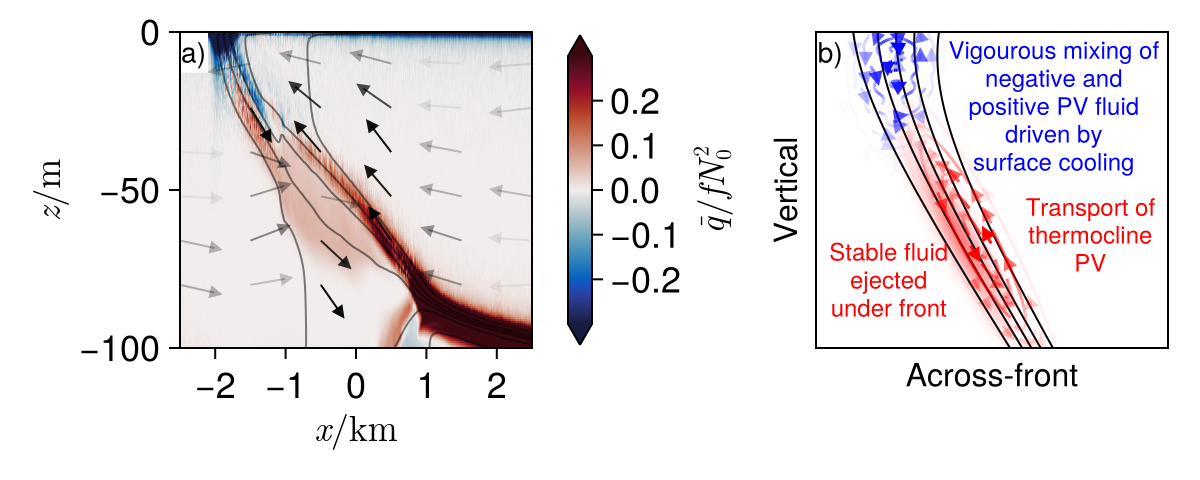

In [46]:
xs = range(-1.0, 1.2, 1000)
zs = range(-1, 0, 1000)

fig = Figure(; size=(600, 240), fontsize=18)
ax = Axis(fig[1, 3]; xlabel="Across-front", ylabel="Vertical", ylabelsize=16, xlabelsize=16)

arrest_x = -0.5
arrest_z = -0.1

ψσ = 0.1
dx = arrest_x - 0.5
dz = arrest_z - 1.0
dl = sqrt(dx^2 + dz^2)
arrest_n = [dx; dz] ./ dl
arrest_m = [-dz; dx] ./ dl

entrainment_x = arrest_x - dx / 2
entrainment_z = arrest_z + dz / 2

Σ² = arrest_n * (4/ψσ^2) * transpose(arrest_n) + arrest_m * (40/dl^2) * transpose(arrest_m)

# Arrest region streamfunction 
function arrest_ψ(x, z) 
    r = (x-arrest_x)^2 + (z-arrest_z)^2
    -exp(-r / 2ψσ^2) * (1 + 0.2 * sin(100z))
end

arrest_colormap = [RGBA(0, 0, 1, 0), RGBA(0, 0, 1, 1)]

arrest_u(x, z) = -(arrest_ψ(x, z+5e-5) - arrest_ψ(x, z-5e-5)) / 1e-4
arrest_w(x, z) = (arrest_ψ(x+5e-5, z) - arrest_ψ(x-5e-5, z)) / 1e-4

arrest_U(x, z) = Point2(arrest_u(x, z), arrest_w(x, z))

# Entrainment region streamfunction
function entrainment_ψ(x, z) 
    r = [x-entrainment_x; z-entrainment_z]
    -exp(-transpose(r) * Σ² * r/ 2)
end
entrainment_colormap = [RGBA(1, 0, 0, 0), RGBA(1, 0, 0, 1)]

function entrainment_u(x, z) 
    u = -(entrainment_ψ(x, z+5e-5) - entrainment_ψ(x, z-5e-5)) / 1e-4
    return u
end
function entrainment_w(x, z) 
    w = (entrainment_ψ(x+5e-5, z) - entrainment_ψ(x-5e-5, z)) / 1e-4
    return w
end

entrainment_U(x, z) = Point2(entrainment_u(x, z), entrainment_w(x, z))

function buoyancy(x, z)
    tanh(3abs(z-1)*(x -(-1+0.5* sqrt(1+(2.5z)^2))))
end

function underneath(x, z) 
    -entrainment_ψ(x+0.1, z)
end

heatmap!(ax, xs, zs, underneath; colormap=entrainment_colormap, colorrange=(0, 2))

contour!(ax, xs, zs, buoyancy; color=:black)
streamplot!(ax, arrest_U, xs, zs; colormap=arrest_colormap, arrow_size=10)
streamplot!(ax, entrainment_U, xs, zs; colormap=entrainment_colormap, arrow_size=10)
gl = GridLayout(fig[1, 3], 
    tellwidth = false, 
    tellheight = false, 
    halign = 0.95, 
    valign = 0.3,
)
Label(gl[1, 1], "Transport of\nthermocline\nPV";
    fontsize=12,
    padding = (1, 1, 2, 2),
    color=:red
)
gl = GridLayout(fig[1, 3], 
    tellwidth = false, 
    tellheight = false, 
    halign = 0.95, 
    valign = 1.0,
)
Label(gl[1, 1], "Vigourous mixing of\nnegative and\npositive PV fluid\ndriven by\nsurface cooling";
    fontsize=12,
    padding = (1, 1, 2, 2),
    color=:blue
)

gl = GridLayout(fig[1, 3], 
    tellwidth = false, 
    tellheight = false, 
    halign = 0.05, 
    valign = 0.1,
)
Label(gl[1, 1], "Stable fluid\nejected\nunder front";
    fontsize=12,
    padding = (1, 1, 2, 2),
    color=:red
)
hidexdecorations!(ax; label=false)
hideydecorations!(ax; label=false)



q = time_average_of(joinpath(foldername, "PV.jld2"), "q_dfm", iterations[901:1001]) do field
    filt(field, 0, 0) ./ (sp.f * sp.N₀²)
end

uq = time_average_of(joinpath(foldername, "PV.jld2"), "uq_dfm", iterations[901:1001]) do field
    filt(field, 0, 0) ./ (sp.f * sp.N₀²)
end
wq = time_average_of(joinpath(foldername, "PV.jld2"), "wq_dfm", iterations[901:1001]) do field
    filt(field, 0, 0) ./ (sp.f * sp.N₀²)
end

b = time_average_of(a->a, joinpath(foldername, "DFM.jld2"), "b_dfm", iterations[911:1001])
# Extremely smoothed versions of the secondary circulation?
u = time_average_of(a->a, joinpath(foldername, "DFM.jld2"), "u_dfm", iterations[911:1001]) .+ [-sp.α * x for x in xsᶠ, z in 1:1]
w = time_average_of(a->a, joinpath(foldername, "DFM.jld2"), "w_dfm", iterations[911:1001])

# Interpolate u and w
u_interp = linear_interpolation((xsᶠ, zsᶜ), u; extrapolation_bc=Linear())
w_interp = linear_interpolation((xsᶜ, zsᶠ), w; extrapolation_bc=Linear())

function sc_vec(x, z)
    2e4 .* Point2(u_interp(sp.Lh * x, sp.H * z) / sp.Lh, w_interp(sp.Lh * x, sp.H * z) / sp.H)
end


colormap = to_colormap(:balance)

ax = Axis(fig[1, 1]; xlabel=L"x / \text{km}", ylabel=L"z / \text{m}", limits=(-sp.Lh / 2000, sp.Lh / 2000, -sp.H, 0), xticks=[-2, -1, 0, 1, 2])
ht = heatmap!(ax, xsᶠ ./ 1000, zsᶜ, q; colormap, colorrange=(-0.3, 0.3), highclip=colormap[end], lowclip=colormap[1])
contour!(ax, xsᶜ ./ 1000, zsᶜ, b; color=(:black, 0.5), levels=b_levels)

ax = Axis(fig[1, 1]; limits=(-0.5, 0.5, -1, 0))
hidexdecorations!(ax)
hideydecorations!(ax)

sc_colormap = [RGBA(0, 0, 0, 0), RGBA(0, 0, 0, 1)]

sc_xs = range(-0.5, 0.5, 6)
sc_zs = range(-0.8, -0.1, 6)
sc_us = [sc_vec(x, z)[1] for x in sc_xs, z in sc_zs]
sc_vs = [sc_vec(x, z)[2] for x in sc_xs, z in sc_zs]

using LinearAlgebra
sc_color = sqrt.(sc_us.^2 .+ sc_vs.^2)
sc_us = sc_us ./ sc_color
sc_vs = sc_vs ./ sc_color
sc_color = vec(sqrt.(0sc_us.^2 .+ sc_vs.^2))

arrows!(ax, sc_xs, sc_zs, sc_us, sc_vs; colormap=sc_colormap, lengthscale = 0.1, color=sc_color)

Colorbar(fig[1, 2], ht; label=L"\overline{q} / fN_0^2")

subfig_label!(fig[1, 1], 1)
subfig_label!(fig[1, 3], 2)

save("figures/paper/cartoon.png", fig; px_per_unit=2)

fig

## Hovmoller

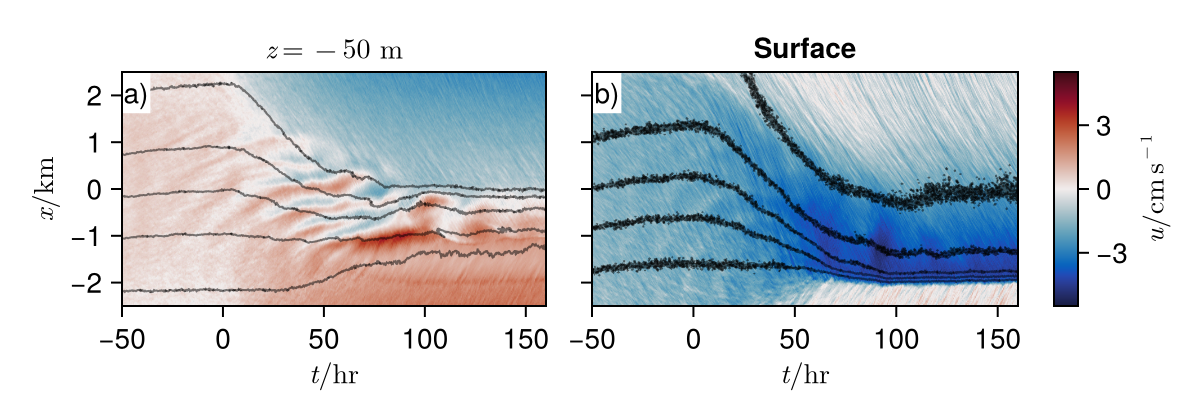

In [59]:
include("src-fig/hovmoller.jl")

# Presentation
#fig = hovmoller(foldername, -50; ax_kw=(; limits=(0, 120, -2.5, 2.5)), ht_kw=(; colorrange=(-0.055, 0.055)), σ=0, fig_kw=(; size=(800, 320), fontsize=18), background=true)
#save("figures/presentation/hovmoller.png", fig; px_per_unit=2)
#save("figures/presentation/hovmoller.svg", fig)

# Paper
fig = hovmoller(foldername, -50; fig_kw=(; size=(600, 210)), ax_kw=(; limits=(-50, 160, -2.5, 2.5), xticks=[-50, 0, 50, 100, 150]), ht_kw=(; colorrange=(-5.5, 5.5)), σ=0, background=true)
save("figures/paper/hovmoller.png", fig; px_per_unit=2)
#save("figures/paper/hovmoller.svg", fig)

fig

## Across-front velocity

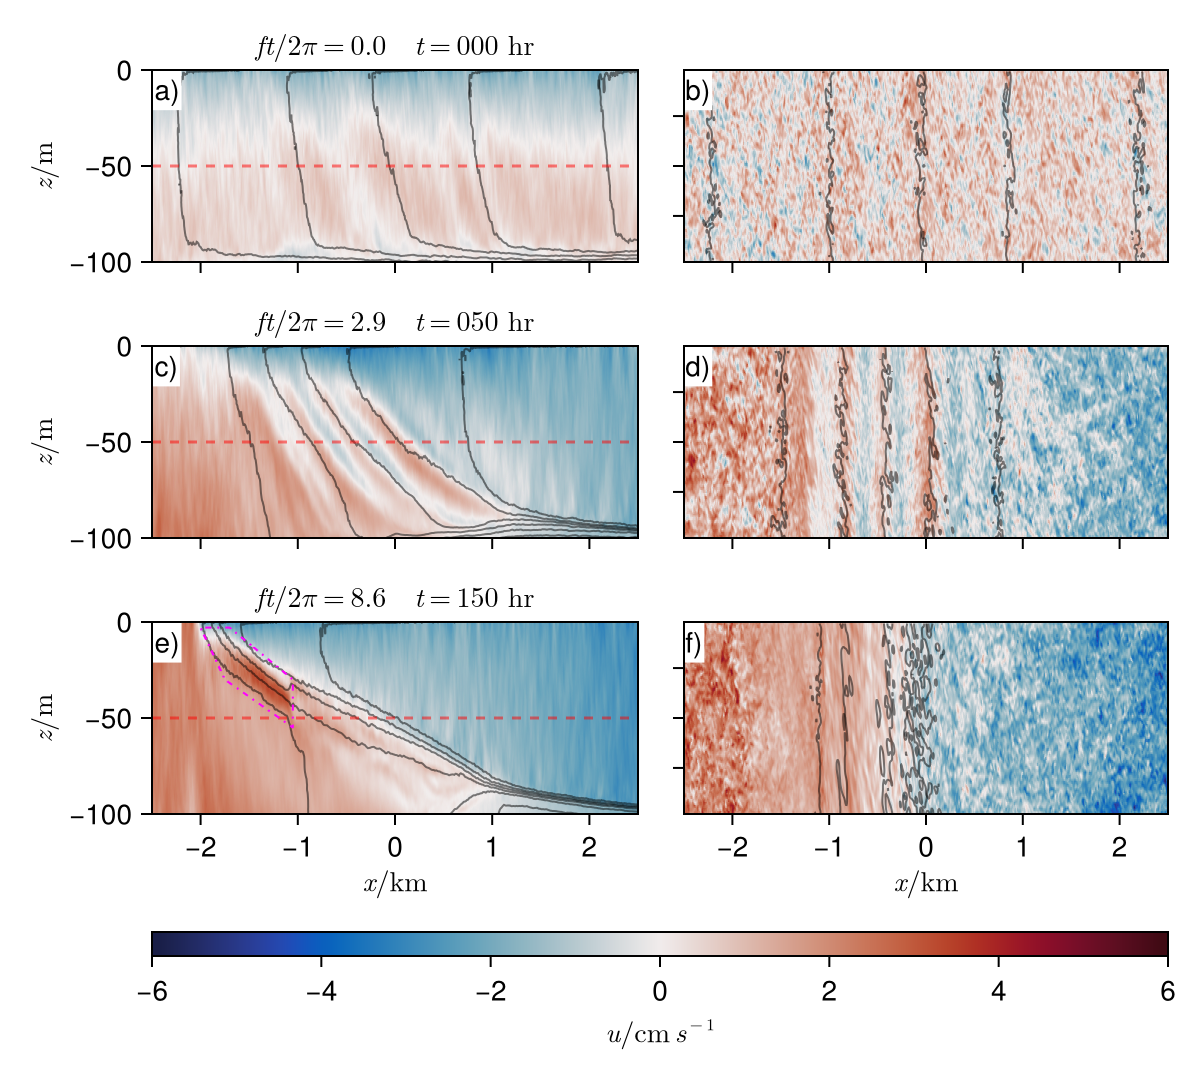

In [58]:
include("src-fig/u_evolution.jl")
include("src-fig/regions.jl")

# Presentation
fig = u_evolution(foldername, frames, -50, regions.arrest; fig_kw=(; size=(800, 720), fontsize=18), background=true)
#save("figures/presentation/u-evolution.svg", fig)
#save("figures/presentation/u-evolution.png", fig; px_per_unit=2)

# Snapshots
#for frame in frames
#    fig = u_evolution(foldername, [frame], -50; fig_kw=(; size=(800, 320), fontsize=18), background=true)
#    save("figures/presentation/snapshot_$frame.png", fig; px_per_unit=2)
#end
# Paper
fig = u_evolution(foldername, frames, -50, regions.arrest; fig_kw=(; size=(600, 540)), background=true, ht_kw=(; colorrange=(-6, 6)))
#save("figures/paper/u-evolution.svg", fig)
save("figures/paper/u-evolution.png", fig; px_per_unit=2)

fig

## Turbulent kinetic energy

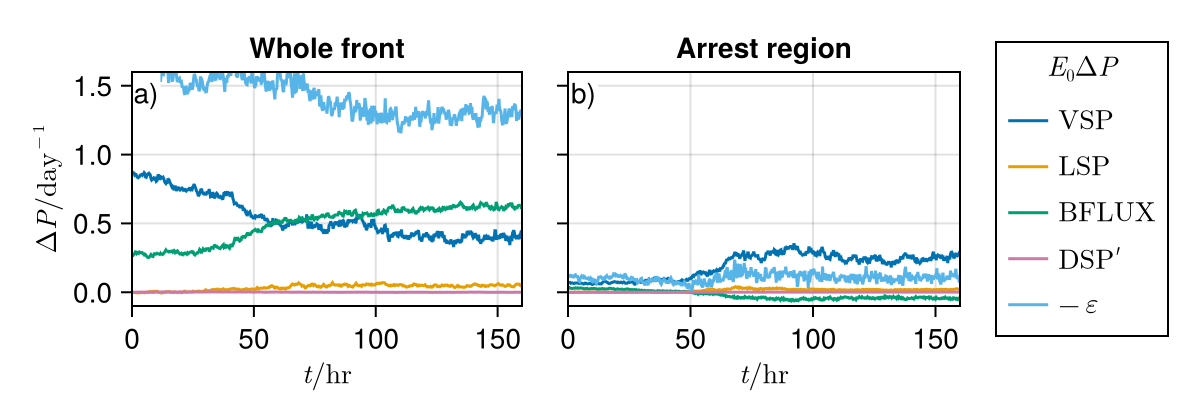

In [35]:
include("src-fig/region_plots.jl")
include("src-fig/regions.jl")

# Presentation
#fig = tke_by_region(foldername, []; ax_kw=(; limits=(0, 200, -1.3, 1.3)), fig_kw=(; fontsize=18))
#save("figures/presentation/tke.svg", fig)
#save("figures/presentation/tke.png", fig; px_per_unit=2)

# Paper
fig = tke_by_region(foldername, []; fig_kw=(; size=(600, 210)), ax_kw=(; xticks=[0, 50, 100, 150], limits=(0, 160, -0.1, 1.6)))
#save("figures/paper/tke.svg", fig)
save("figures/paper/tke.png", fig; px_per_unit=2)

fig

## Potential vorticity

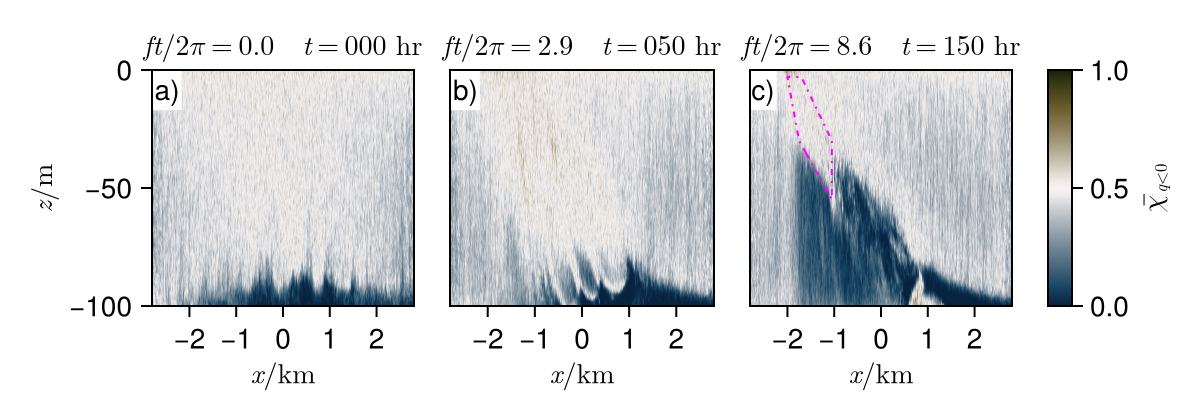

In [36]:
include("src-fig/regions.jl")
include("src-fig/pv_plot.jl")

# Presentation
#fig = instability_plot(foldername, [1, 230, 360]; fig_kw=(; size=(800, 240), fontsize=18), ax_kw=(; xticks=-2:2))
#save("figures/presentation/pv.svg", fig)
#save("figures/presentation/pv.png", fig; px_per_unit=2)

# Paper
fig = instability_plot(foldername, frames, regions.arrest; fig_kw=(; size=(600, 210)), ax_kw=(; xticks=-2:2, limits=(-2.8, 2.8, -100, 0)))
#save("figures/paper/pv.svg", fig)
save("figures/paper/pv.png", fig; px_per_unit=2)

fig